In [1]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
results_dir = './data/outputs'

name_map = {
    # 'llama_2_7b_hf_mono_merged': 'mono (en)',
    'llama_2_7b_hf_ml1_merged': 'Mono (en)',
    'llama_2_7b_hf_ml2_merged': 'ML2',
    'llama_2_7b_hf_ml3_merged': 'ML3',
    'llama_2_7b_hf_ml4_merged': 'ML4',
    'llama_2_7b_hf_ml5_merged': 'ML5',
    # 'llama_2_7b_hf_en_merged': 'ML6/en',
    'llama_2_7b_hf_de_merged': 'ML6/de',
    'llama_2_7b_hf_fr_merged': 'ML6/fr',
    'llama_2_7b_hf_zh_merged': 'ML6/zh',
    'llama_2_7b_hf_es_merged': 'ML6/es',
    'llama_2_7b_hf_ru_merged': 'ML6/ru',
    'llama_2_7b_hf_ca_merged': 'ML6/ca',
    'alpaca_eval_instructions_en': 'en',
    'alpaca_eval_instructions_de': 'de',
    'alpaca_eval_instructions_fr': 'fr',
    'alpaca_eval_instructions_zh': 'zh',
    'alpaca_eval_instructions_es': 'es',
    'alpaca_eval_instructions_ru': 'ru',
    'alpaca_eval_instructions_it': 'it',
    'alpaca_eval_instructions_is': 'is',
    'alpaca_eval_instructions_hi': 'hi',
    'alpaca_eval_instructions_el': 'el',
    'alpaca_eval_instructions_ca': 'ca',
    'alpaca_eval_instructions_sv': 'sv',
    'alpaca_eval_instructions_no': 'no',
    'alpaca_eval_instructions_da': 'da',
    'alpaca_eval_instructions_bg': 'bg',
}

def load_json(file):
    with open(file, "r", encoding='utf8') as f:
        return json.load(f)

def parse_filename(file):
    """
    data/outputs/llama_2_7b_hf_en_merged/alpaca_eval_instructions_ru-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.eval
    """
    # get test set and context, allowing for no context
    model_name = Path(file).parent.name
    parts = Path(file).stem.split('-')

    test_set = parts[0]
    context = parts[1]
    prompt = parts[2]
    seed = int(parts[3][1:])
    top_k = int(parts[4][1:])
    top_p = float(parts[5][1:])
    temp = float(parts[6][1:])
    bs = int(parts[7][1:])

    return model_name, test_set, prompt, seed


def get_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for eval_file in Path(results_dir).glob('*/*.eval'):
        # print(eval_file)
        df = pd.read_csv(eval_file, index_col=None)
        model_name, test_set, prompt, seed = parse_filename(eval_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
        # # get generation args too
        # try:
        #     hp_file = eval_file.with_suffix(".json")
        #     hps = load_json(hp_file)
        #     eval_dict.update(hps)
        # except:
        #     pass
    
    df = pd.concat(dfs, axis=0, ignore_index=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    df = df.reindex(columns=cols)

    return df

df = get_results(results_dir)
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)
print(len(df))
print(df.columns)
df.head()

316
Index(['model_name', 'test_set', 'seed', 'lang_match', 'tgt_lang', 'ppl',
       'file', 'context', 'n'],
      dtype='object')


,model_name,test_set,seed,lang_match,tgt_lang,ppl,file,context,n
0,Mono (en),de,0,0.391,0.390,24.971,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN
1,Mono (en),de,42,0.416,0.419,22.476,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN
2,Mono (en),de,723,0.411,0.412,22.836,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN
3,Mono (en),en,0,0.944,0.964,14.927,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN
4,Mono (en),en,42,0.933,0.954,20673.208,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN


In [5]:
# sort models given the order in name_map
model_names = df['model_name'].unique()
ordered_model_names = sorted(model_names, key=lambda x: list(name_map.values()).index(x))
print(ordered_model_names)
test_sets = df['test_set'].unique()
ordered_test_sets = sorted(test_sets, key=lambda x: list(name_map.values()).index(x))
print(ordered_test_sets)
ordered_seeds = sorted(df['seed'].unique())
print(ordered_seeds)

def apply_sort(df):

    df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
    df['test_set'] = pd.Categorical(df['test_set'], ordered_test_sets)

    df = df.sort_values(by=['model_name', 'test_set', 'seed'])

    # Convert the columns back to their original data types
    df['model_name'] = df['model_name'].astype(str)
    df['test_set'] = df['test_set'].astype(str)
        
    df = df.reset_index(drop=True)

    return df

# drop columns containing any NaN values
# df = df.dropna(axis=1, how='any')

# sort dataframe
df = apply_sort(df)
# store sort order
# custom_sort_index = df.index.tolist()
# df['idx'] = custom_sort_index
# print(df.columns)
df.head(40)

['Mono (en)', 'ML2', 'ML3', 'ML4', 'ML5', 'ML6/de', 'ML6/fr', 'ML6/zh', 'ML6/es', 'ML6/ru', 'ML6/ca']
['en', 'de', 'fr', 'zh', 'es', 'ru', 'is', 'hi', 'el', 'ca', 'sv', 'no', 'da']
[0, 42, 723]


,model_name,test_set,seed,lang_match,tgt_lang,ppl,file,context,n
0,Mono (en),en,0,0.944,0.964,14.927,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN
1,Mono (en),en,42,0.933,0.954,20673.208,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN
2,Mono (en),en,723,0.938,0.960,18.525,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN
3,Mono (en),de,0,0.391,0.390,24.971,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN
4,Mono (en),de,42,0.416,0.419,22.476,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN
5,Mono (en),de,723,0.411,0.412,22.836,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN
6,Mono (en),fr,0,0.647,0.651,23.453,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN
7,Mono (en),fr,42,0.619,0.622,19.956,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN
8,Mono (en),fr,723,0.635,0.639,17.523,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN
9,Mono (en),zh,0,0.286,0.294,19.257,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt,NaN


In [6]:
def get_results_overview(df, cols=['model_name', 'test_set', 'seed']):
    for col in cols:
        print(f'*** {col} ***')
        print(df[col].value_counts())
        print()

get_results_overview(df)

*** model_name ***
model_name
ML6/de       36
ML6/fr       36
ML6/zh       36
ML6/es       36
ML6/ru       36
Mono (en)    24
ML2          24
ML3          24
ML4          24
ML5          24
ML6/ca       16
Name: count, dtype: int64

*** test_set ***
test_set
en    33
de    33
el    33
fr    30
zh    30
ru    30
is    30
hi    30
ca    18
es    16
sv    15
no    15
da     3
Name: count, dtype: int64

*** seed ***
seed
0      106
42     105
723    105
Name: count, dtype: int64



In [7]:
def get_agg_df(df, group_cols=['model_name', 'test_set'], agg_ops={'lang_match': np.mean, 'tgt_lang': np.mean, 'ppl': np.mean}):
    """
    Aggregates the results of the different strategies.
    If use_macro is True, then the macro-averaged results are used, otherwise the micro-averaged results are used.
    """
    df = df.groupby(group_cols, as_index=True).agg(agg_ops)
    # df = df.reindex(['0-shot', '1-shot', 'Mem-4', 'Mem-8', 'L2M'])
    # df[df.select_dtypes(include=['number']).columns] *= 100
    df = df.round(2)
    return df

def styled_df(df, color):
    return df.style.background_gradient(axis=0, text_color_threshold=0, cmap=sns.light_palette(color, as_cmap=True)).highlight_max(axis=0, props='font-weight:bold;').format(precision=2)

styled_df(get_agg_df(df), 'seagreen')

/tmp/ipykernel_2446822/1217292084.py:6: FutureWarning: The provided callable <function mean at 0x7f4d70713520> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(group_cols, as_index=True).agg(agg_ops)
/tmp/ipykernel_2446822/1217292084.py:6: FutureWarning: The provided callable <function mean at 0x7f4d70713520> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(group_cols, as_index=True).agg(agg_ops)


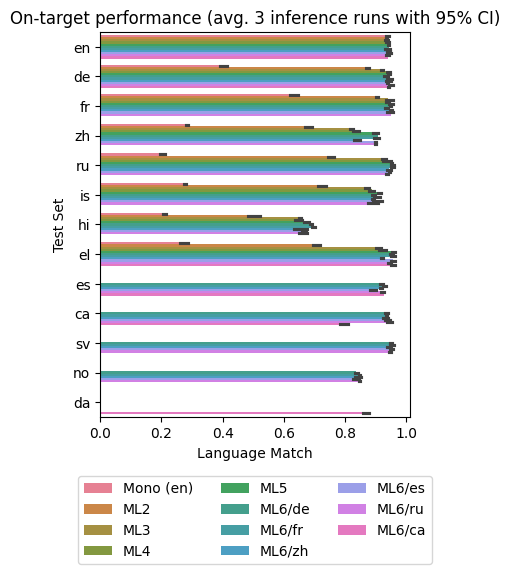

In [8]:
# plot bar plots of lang_match
fig, ax = plt.subplots(figsize=(4, 5))

sns.barplot(data=df,
            x='lang_match', y='test_set', 
            hue='model_name', errorbar='ci', 
            orient='h',
            ax=ax)

ax.set_title('On-target performance (avg. 3 inference runs with 95% CI)')
ax.set_xlabel('Language Match')
ax.set_ylabel('Test Set')

# legend at bottom
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3)

fig.savefig('data/plots/llama2_7b_lang_match.png', bbox_inches='tight', dpi=300)


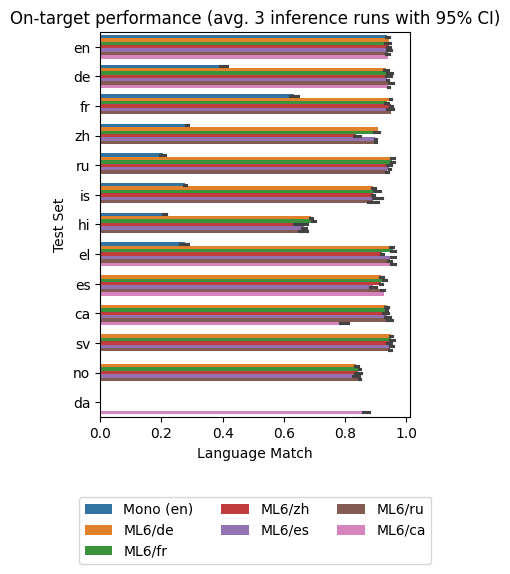

In [9]:
# plot bar plots of lang_match
fig, ax = plt.subplots(figsize=(4, 5))

sns.barplot(data=df[~df['model_name'].isin(['ML2', 'ML3', 'ML4', 'ML5'])],
            x='lang_match', y='test_set', 
            hue='model_name', 
            errorbar='ci', capsize=0.002,
            orient='h',
            ax=ax)

ax.set_title('On-target performance (avg. 3 inference runs with 95% CI)')
ax.set_xlabel('Language Match')
ax.set_ylabel('Test Set')

# legend at bottom
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3)

fig.savefig('data/plots/llama2_7b_lang_match.png', bbox_inches='tight', dpi=300)


In [30]:
def get_generations(results_dir):
    dfs = []
    for generations_file in Path(results_dir).glob('*/*.llm_eval'):
        # print(eval_file)
        df = pd.read_json(generations_file, lines=True)
        model_name, test_set, prompt, seed = parse_filename(generations_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
    df = pd.concat(dfs, axis=0, ignore_index=False)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    # cols.insert(0, df.ndex)
    df = df.reindex(columns=cols)

    return df

gen_df = get_generations(results_dir)

gen_df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)
print(len(gen_df))
print(gen_df.columns)
gen_df.head()

# data/outputs/llama_2_7b_hf_zh_merged/alpaca_eval_instructions_zh-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8-gpt_3.5_turbo-l50.llm_eval

3750
Index(['model_name', 'test_set', 'seed', 'prompt', 'system', 'finish_reason',
       'source', 'secs', 'source_lang', 'system_lang', 'id',
       'gpt-3.5-turbo-judgement', 'gpt-3.5-turbo-justification',
       'gpt-3.5-turbo-cost', 'context', 'gpt-4-judgement',
       'gpt-4-justification', 'gpt-4-cost'],
      dtype='object')


,model_name,test_set,seed,prompt,system,finish_reason,source,secs,source_lang,system_lang,id,gpt-3.5-turbo-judgement,gpt-3.5-turbo-justification,gpt-3.5-turbo-cost,context,gpt-4-judgement,gpt-4-justification,gpt-4-cost
0,ML6/de,de,42,"### Human: ""Warum fühlt man sich durch Wärme m...",Die Frage nach dem Verständnis der psychologis...,stop,"""Warum fühlt man sich durch Wärme müde?""",1.623084,deu_Latn,deu_Latn,193,Excellent,"informative, interesting",0.001520,guanaco_prompt,NaN,NaN,NaN
1,ML6/de,de,42,"### Human: ""Erklären Sie, was das unterstriche...","Für Kinder ist das unterstrichene Wort ""ein Ve...",stop,"""Erklären Sie, was das unterstrichene Wort für...",0.935782,deu_Latn,deu_Latn,719,Excellent,"informative, interesting",0.001094,guanaco_prompt,NaN,NaN,NaN
2,ML6/de,de,42,"### Human: ""Eins Eins war ein Rennpferd. Zwei ...","In dieser Geschichte gibt es zwei Pferde, ein ...",stop,"""Eins Eins war ein Rennpferd. Zwei Zwei war au...",1.396412,deu_Latn,deu_Latn,169,Excellent,"informative, interesting",0.000906,guanaco_prompt,NaN,NaN,NaN
3,ML6/de,de,42,"### Human: ""Dir wird eine Beschreibung gegeben...",Als Reaktion auf die geplante russische Invasi...,stop,"""Dir wird eine Beschreibung gegeben, die eine ...",1.525187,deu_Latn,deu_Latn,523,Fail,language,0.001013,guanaco_prompt,NaN,NaN,NaN
4,ML6/de,de,42,"### Human: ""Dir wird ein Thema für einen Insta...","""Beitrag zum Instagram-Beitrag über Frauen in ...",stop,"""Dir wird ein Thema für einen Instagram-Beitra...",1.177709,deu_Latn,deu_Latn,537,Excellent,"informative, interesting",0.000775,guanaco_prompt,NaN,NaN,NaN


In [31]:
gen_df['model_name_test_set'] = gen_df['model_name'] + ' ' + gen_df['test_set']

fig_width: 6, fig_height: 4.0, subplot_height: 0.16666666666666666
ML6/zh zh: {'Excellent': 24.0, 'Pass': 21.333333333333336, 'Fail': 54.666666666666664}
ML6/zh ru: {'Excellent': 17.333333333333336, 'Pass': 14.666666666666666, 'Fail': 68.0}
ML6/zh is: {'Excellent': 1.3333333333333335, 'Pass': 15.333333333333332, 'Fail': 83.33333333333334}
ML6/zh hi: {'Excellent': 9.333333333333334, 'Pass': 22.666666666666664, 'Fail': 68.0}
ML6/zh fr: {'Excellent': 67.33333333333333, 'Pass': 12.0, 'Fail': 20.666666666666668}
ML6/zh en: {'Excellent': 82.66666666666667, 'Pass': 4.666666666666667, 'Fail': 12.666666666666668}
ML6/zh el: {'Excellent': 0.6666666666666667, 'Pass': 11.333333333333332, 'Fail': 88.0}
ML6/zh de: {'Excellent': 70.0, 'Pass': 18.0, 'Fail': 12.0}
ML6/ru zh: {'Excellent': 33.33333333333333, 'Pass': 18.0, 'Fail': 48.66666666666667}
ML6/ru ru: {'Excellent': 14.000000000000002, 'Pass': 11.333333333333332, 'Fail': 74.66666666666667}
ML6/ru is: {'Excellent': 4.666666666666667, 'Pass': 5.333

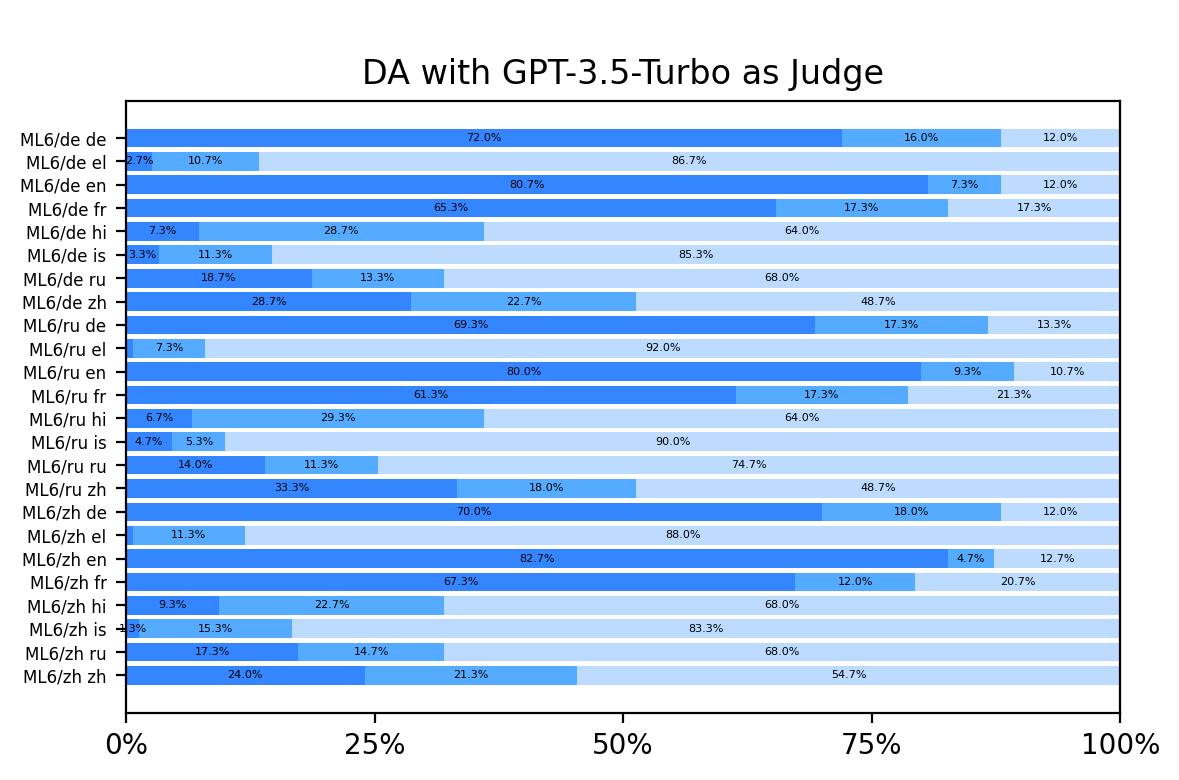

In [60]:
def calculate_legend_bbox(subplot_height, figsize_height, margin_fraction=0.1):
    # Calculate the margin as a fraction of the subplot height
    margin = margin_fraction * subplot_height

    # Calculate the bbox_to_anchor value
    bbox_to_anchor = (0.5, -margin / figsize_height)

    return bbox_to_anchor

def calculate_figure_height(num_items, target_aspect_ratio):
    # Calculate the width of the figure based on the target aspect ratio
    fig_width = 6
    fig_height = fig_width / target_aspect_ratio

    # Calculate the subplot height based on the number of items
    subplot_height = fig_height / num_items

    return fig_width, fig_height, subplot_height

# plot the judgemtnts for each model
def plot_judgements(df, judge='GPT-3.5-Turbo', title=None, task_id='', output_dir=None, target_aspect_ratio=1.5, margin_fraction=0.5):
    """
    
    """
    
    # models = df['model_name'].unique().tolist()[::-1]
    test_sets = df['model_name_test_set'].unique().tolist()[::-1]

    # Calculate the figure width, height, and subplot height
    fig_width, fig_height, subplot_height = calculate_figure_height(len(test_sets), target_aspect_ratio=target_aspect_ratio)
    print(f'fig_width: {fig_width}, fig_height: {fig_height}, subplot_height: {subplot_height}')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_width, fig_height), sharey=True, sharex=True, dpi=200, tight_layout=True)

    colors = {'Excellent': '#0068FF', 'Pass': '#2B96FF', 'Fail': '#ABD2FF'}

    # for i, model in enumerate(models):
        # print(model)
    for j, test_set in enumerate(test_sets):
        # print(test_set)
        # sdf = df[(df['model_name'] == model) & (df['test_set'] == test_set)]
        sdf = df[df['model_name_test_set'] == test_set]
        # print(len(sdf))
        # print(sdf.columns)
        if judge == 'GPT-3.5-Turbo':
            results = sdf['gpt-3.5-turbo-judgement'].value_counts(normalize=True).to_dict()
        elif judge == 'GPT-4':
            results = sdf['gpt-4-judgement'].value_counts(normalize=True).to_dict()
        else:
            raise ValueError(f'Unknown judge: {judge}')
        
        # sort order: 'Excellent, Pass, Fail'
        results = {k: results.get(k, 0.0) for k in ['Excellent', 'Pass', 'Fail']}
        # multiply by 100 to get percentage
        results = {k: v * 100 for k, v in results.items()}

        print(f'{test_set}: {results}')

        prev_val = 0
        for k, v in results.items():

            ax.barh(y=j, width=v, height=0.8, left=prev_val, 
                    color=colors[k], alpha=0.8, # set the color of each bar individually
                    label=k if j == 0 else "", # label the first bar in each stack with the model name
                    )
            
            # label bar with value
            if v > 1:
                ax.text(x=prev_val + v/2, y=j, s=f'{v:.1f}%', ha='center', va='center', fontsize=4)

            # add the value of each bar to the previous value
            prev_val += v
    
            # # hide legend for all but the first model
            # if i == 0 and j > 0:
            #     ax.get_legend().remove()


    # Set the y-ticks to be the model names
    ax.set_yticks(np.arange(len(test_sets)), test_sets, fontsize=6)
    ax.set_xlabel('')

    ax.set_xticks([0, 25, 50, 75, 100], ['0%', '25%', '50%', '75%', '100%'], minor=False)
    # ax.set_xticklabels()

    # remove x-axis ticks
    # ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    # # put the legend out of the plot and center it
    # # if len(models) > 2:
    # bbox_to_anchor = calculate_legend_bbox(subplot_height, fig_height, margin_fraction=margin_fraction)
    # print(bbox_to_anchor)
    # ax.legend(bbox_to_anchor=bbox_to_anchor, loc='lower center', ncol=3, frameon=False)# , fontsize=8)
    # # else:
    # #     ax.legend(bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=3, frameon=False, fontsize=8)

    # Adjust the margins
    plt.margins(y=0.05, x=0.0)

    # title of plot
    if not title:
        ax.set_title(f'{task_id}\nDA with {judge} as Judge')
    else:
        ax.set_title(title)

    if output_dir is not None:
        outfile = Path(output_dir) / f'da_judge_{judge}-{task_id}.png'
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
        print(f'Saved to {outfile}')

    return

plot_judgements(gen_df, judge='GPT-3.5-Turbo')

fig_width: 6, fig_height: 4.0, subplot_height: 0.16666666666666666
ML6/zh zh: {'Excellent': 70.0, 'Pass': 8.0, 'Fail': 22.0}
ML6/zh ru: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh is: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh hi: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh fr: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh en: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh el: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/zh de: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru zh: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru ru: {'Excellent': 66.0, 'Pass': 6.0, 'Fail': 28.000000000000004}
ML6/ru is: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru hi: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru fr: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru en: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru el: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/ru de: {'Excellent': 0.0, 'Pass': 0.0, 'Fail': 0.0}
ML6/de zh: {'Excell

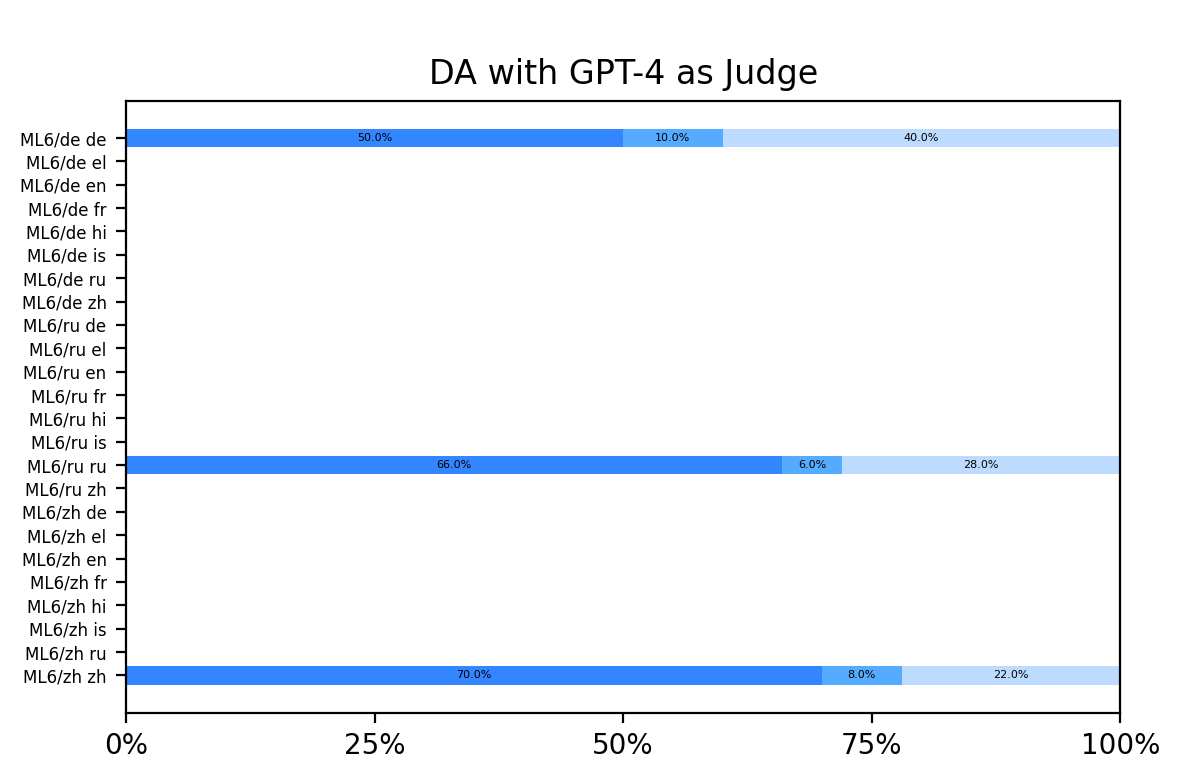

In [62]:
plot_judgements(gen_df, judge='GPT-4')


In [67]:
gen_df['gpt-4-justification'].value_counts()

gpt-4-justification
informative, interesting, correct                                                                                                                                                                                                                                   42
informative, interesting, and correct                                                                                                                                                                                                                               20
incorrect information                                                                                                                                                                                                                                                5
informative, correct, and detailed                                                                                                                                                             

In [68]:
gen_df['gpt-3.5-turbo-justification'].value_counts()

gpt-3.5-turbo-justification
language                                                                                                                                                                                                 1810
informative, interesting                                                                                                                                                                                 1112
grammatical, sufficient                                                                                                                                                                                   263
grammatical, informative                                                                                                                                                                                   92
grammatical                                                                                                                                         

In [14]:
# inspect off-target generations in output files

def get_generations(results_dir):
    dfs = []
    for generations_file in Path(results_dir).glob('*/*.jsonl'):
        # print(eval_file)
        df = pd.read_json(generations_file, lines=True)
        model_name, test_set, prompt, seed = parse_filename(generations_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
    df = pd.concat(dfs, axis=0, ignore_index=False)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    # cols.insert(0, df.ndex)
    df = df.reindex(columns=cols)

    return df

gen_df = get_generations(results_dir)
gen_df

,model_name,test_set,seed,prompt,system,finish_reason,source,secs,source_lang,system_lang,context
0,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie lauten die Namen einiger berüh...",Here are some famous actors who began their ca...,stop,"""Wie lauten die Namen einiger berühmter Schaus...",2.562441,deu_Latn,eng_Latn,guanaco_prompt
1,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie haben die US-Bundesstaaten ihr...",Die Staaten der Vereinigten Staaten von Amerik...,length,"""Wie haben die US-Bundesstaaten ihre Namen erh...",2.562441,deu_Latn,deu_Latn,guanaco_prompt
2,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Hallo, meine Schwester und ihre Fr...",Sure! Kickball is a game that combines element...,stop,"""Hallo, meine Schwester und ihre Freundinnen m...",2.562441,deu_Latn,eng_Latn,guanaco_prompt
3,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Was sind einige coole Musikstücke ...","""Die 20er Jahre waren eine Zeit des wirtschaft...",stop,"""Was sind einige coole Musikstücke aus den 192...",2.562441,deu_Latn,deu_Latn,guanaco_prompt
4,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie verpacke ich ein Geschenk orde...","""Ein Geschenk verpacken ist eine wichtige Sach...",stop,"""Wie verpacke ich ein Geschenk ordentlich?""",2.562441,deu_Latn,deu_Latn,guanaco_prompt
...,...,...,...,...,...,...,...,...,...,...,...
800,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一段YouTube视频撰写剧本，探索爵士乐的历史和文化意义。### ...,"[推荐视频]\n\n<iframe width=""560"" height=""315"" src...",stop,为一段YouTube视频撰写剧本，探索爵士乐的历史和文化意义。,3.112936,NaN,NaN,guanaco_prompt
801,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 撰写一篇有趣的旅行博客文章，介绍最近去夏威夷的旅行，重点突出文化体验和...,![](https://cdn-images-1.medium.com/max/1600/1...,stop,撰写一篇有趣的旅行博客文章，介绍最近去夏威夷的旅行，重点突出文化体验和必看景点。,3.112936,NaN,NaN,guanaco_prompt
802,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一部最近上映的科幻电影撰写一个引人入胜的影评，讨论其剧情、角色和特效...,电影《黑洞之魂》简介\n\n《黑洞之魂》是一部2021年上映的科幻电影，由迈克尔·杰克逊导演...,stop,为一部最近上映的科幻电影撰写一个引人入胜的影评，讨论其剧情、角色和特效。,3.112936,NaN,NaN,guanaco_prompt
803,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一集讨论流媒体平台对音乐产业影响的播客脚本进行构建。### Assi...,[一句话简介]\n\n我们将讨论流媒体平台对音乐产业的影响，并对此进行探讨。我们将从三个角度...,stop,为一集讨论流媒体平台对音乐产业影响的播客脚本进行构建。,3.112936,NaN,NaN,guanaco_prompt


In [15]:
# def inspect_longer_strings(text):
#     # escape newlines
#     text = text.replace('\n', '\\n')
#     text_ = text[:100]
#     if len(text) > len(text_):
#         text_ += '...'
#     return text_

# for i, row in gen_df.iterrows():
#     expected_lang = row['test_set'][-2:]
#     # print(expected_lang)
#     if row['system_lang'] != expected_lang:
#         print(i, inspect_longer_strings(row['source']))
#         print(row['system_lang'], inspect_longer_strings(row['system']))
#         print('*****')
#         # break

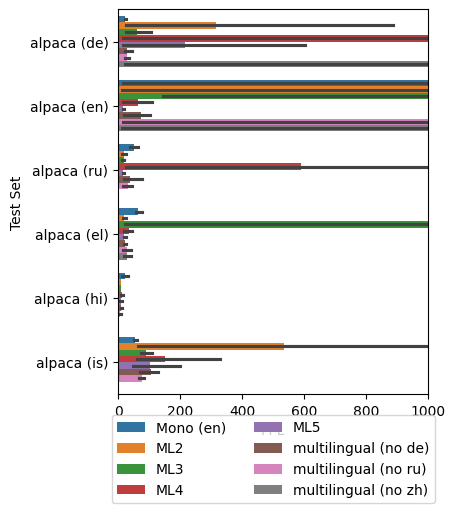

In [16]:
# plot bar plots of lang_match

fig, ax = plt.subplots(figsize=(4, 5))

sns.barplot(x='ppl', y='test_set', hue='model_name', errorbar='ci', orient='h', data=df, ax=ax)

ax.set_xlabel('PPL')
ax.set_ylabel('Test Set')

ax.set_xlim(0, 1000)
# legend at bottom
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)



In [ ]:
# # sort models given the order in name_map
# model_names = df['model_name'].unique()
# ordered_model_names = sorted(model_names, key=lambda x: list(name_map.values()).index(x))
# print(ordered_model_names)
# ordered_test_sets = sorted(df['test_set'].unique())
# print(ordered_test_sets)
# ordered_seeds = sorted(df['seed'].unique())
# print(ordered_seeds)

# def apply_sort(df):

#     df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)

#     df['context'] = pd.Categorical(df['context'], ordered_contexts)

#     df = df.sort_values(by=['test_set', 'model_name', 'context', 'seed'])

#     # Convert the columns back to their original data types
#     df['model_name'] = df['model_name'].astype(str)
#     df['context'] = df['context'].astype(str)
        
#     df = df.reset_index(drop=True)

#     return df

# # drop columns containing any NaN values
# # df = df.dropna(axis=1, how='any')

# # sort dataframe
# df = apply_sort(df)

# # store sort order
# custom_sort_index = df.index.tolist()
# df['idx'] = custom_sort_index
# print(df.columns)
# df.head(4)